# Predicting Animal Adoptions

### Project Goal:

Using a few simple inputs (related to animal type, age of animal, color, etc), build an online tool that will predict whether an animal will be adopted or not from the Austin Animal Center.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 25)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix

## Data Exploration and Merging

Data Sources:
- [Austin Animal Center Intakes Data](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm)
- [Austin Animal Center Outcomes Data](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)

In [2]:
# Read in intakes data, downloaded 9/19/22
df_in = pd.read_csv('data/Austin_Animal_Center_Intakes-091922.csv',
                    parse_dates=['DateTime'])
df_in.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A665644,NaN,2013-10-21 07:59:00,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
1,A664262,NaN,2013-10-01 11:45:00,October 2013,4915 Yager Ln in Austin (TX),Stray,Normal,Cat,Intact Male,1 weeks,Domestic Shorthair Mix,Orange Tabby
2,A664887,*Gia,2013-10-10 13:48:00,October 2013,1901 Onion Creek Pkwy in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Shorthair Mix,Black
3,A665800,*Precious,2013-10-23 11:08:00,October 2013,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,3 months,Domestic Shorthair Mix,Tortie
4,A665763,NaN,2013-10-22 15:10:00,October 2013,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White


In [3]:
# Read in outcomes data, downloaded 9/19/22
df_out = pd.read_csv('data/Austin_Animal_Center_Outcomes-091922.csv', 
                     parse_dates=['DateTime'])
df_out.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,2020-08-16 11:38:00,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,2014-03-18 11:47:00,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


In [4]:
# There are some duplicate rows with the exact same Animal ID and DateTime
# Assuming input issues (ie accidentally entering the animal into the system twice)
print(f"Intake dupes: {df_in.duplicated(subset=['Animal ID', 'DateTime']).sum()}")
print(f"Outcome dupes: {df_out.duplicated(['Animal ID', 'DateTime']).sum()}")

Intake dupes: 27
Outcome dupes: 19


In [5]:
# Dropping these dupes, keeping the last entry
df_in = df_in.drop_duplicates(subset=['Animal ID', 'DateTime'], keep='last')
df_out = df_out.drop_duplicates(subset=['Animal ID', 'DateTime'], keep='last')

### Data Cleaning: Merging Repeat Intakes/Outcomes

In [6]:
# First - order both dfs by DateTime
df_in = df_in.sort_values(by='DateTime')
df_out = df_out.sort_values(by='DateTime')

In [7]:
# Create iterative counts for animals that have multiple intakes/outcomes
df_in['Intake Num'] = df_in.groupby('Animal ID', sort=False).cumcount()+1
df_out['Outcome Num'] = df_out.groupby('Animal ID', sort=False).cumcount()+1

In [8]:
# Checking a known repeat offender - multiple intakes ...
df_in.loc[df_in['Animal ID'] == 'A721033'].tail(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Intake Num
58270,A721033,Lil Bit,2019-04-26 10:28:00,April 2019,South 1St And Stassney in Austin (TX),Public Assist,Normal,Dog,Neutered Male,3 years,Rat Terrier Mix,Tricolor/Brown Brindle,29
15175,A721033,Lil Bit,2019-05-20 10:18:00,May 2019,1819 South Pleasant Valley Road in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,30
40853,A721033,Lil Bit,2019-08-05 10:52:00,August 2019,Burton And Oltorf in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,31
109528,A721033,Lil Bit,2019-09-16 14:06:00,September 2019,Justin Lane And North Lamar in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,32
31427,A721033,Lil Bit,2019-10-05 12:31:00,October 2019,1135 Airport Boulevard in Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,33


In [9]:
# ... and multiple outcomes
df_out.loc[df_out['Animal ID'] == 'A721033'].tail(5)

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Outcome Num
31114,A721033,Lil Bit,2019-05-04 08:37:00,May 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,3 years,Rat Terrier Mix,Tricolor/Brown Brindle,29
19628,A721033,Lil Bit,2019-05-21 14:42:00,May 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,30
4945,A721033,Lil Bit,2019-08-10 11:56:00,Aug 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,31
67961,A721033,Lil Bit,2019-09-19 11:02:00,Sep 2019,05/20/2015,Return to Owner,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,32
73079,A721033,Lil Bit,2019-10-20 11:35:00,Oct 2019,05/20/2015,Rto-Adopt,NaN,Dog,Neutered Male,4 years,Rat Terrier Mix,Tricolor/Brown Brindle,33


In [10]:
# Let's try merging using these new iterative count columns
df = df_in.merge(df_out, 
                 left_on=['Animal ID', 'Intake Num'], 
                 right_on=['Animal ID', 'Outcome Num'],
                 how='inner',
                 suffixes=("_in", "_out"))

In [11]:
df.head()

,Animal ID,Name_in,DateTime_in,MonthYear_in,Found Location,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,Name_out,DateTime_out,MonthYear_out,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_out,Sex upon Outcome,Age upon Outcome,Breed_out,Color_out,Outcome Num
0,A521520,Nina,2013-10-01 07:51:00,October 2013,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan,1,Nina,2013-10-01 15:39:00,Oct 2013,09/07/2006,Return to Owner,NaN,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan,1
1,A664236,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1,NaN,2013-10-01 10:44:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1
2,A664237,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1,NaN,2013-10-01 10:44:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1
3,A664235,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1,NaN,2013-10-01 10:39:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1
4,A664233,Stevie,2013-10-01 08:53:00,October 2013,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1,Stevie,2013-10-01 15:33:00,Oct 2013,09/30/2010,Euthanasia,Suffering,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1


In [12]:
# Exploring rows where the simple iterative count didn't work 
# Aka the outcome date was before the intake date
dirty = df.loc[df['DateTime_in'] > df['DateTime_out']]

In [13]:
# Ew - this many rows didn't quite work with a simple iterative count
dirty.shape

(728, 25)

In [14]:
# Subsetting down, for simplicity
dirty = dirty[['Animal ID', 'DateTime_in', 'Intake Num']]

In [15]:
# Going to add 1 to intake num, then try to merge again
dirty['Intake Num'] += 1

In [16]:
dirty.head()

,Animal ID,DateTime_in,Intake Num
203,A663004,2013-10-04 14:11:00,2
288,A663572,2013-10-06 11:00:00,2
426,A663722,2013-10-09 12:11:00,2
427,A663723,2013-10-09 12:11:00,2
609,A663667,2013-10-12 17:17:00,2


In [17]:
# Now let's get a clean version of df_in ready
df_in_clean = df_in.copy()

In [18]:
# Adding columns just on the dirty rows using a left merge
# The Intake Num with "first" was the 1st attempt, "second" is 2nd attempt
df_in_clean = df_in_clean.merge(dirty,
                                left_on=['Animal ID', 'DateTime'], 
                                right_on=['Animal ID', 'DateTime_in'], 
                                how='left',
                                suffixes=('_first', '_second'))

In [19]:
# Don't need an extra datetime column anymore
df_in_clean = df_in_clean.drop(columns=['DateTime_in'])
# If we check, we can see that non-null count in Intake Num_second
# matches the number of dirty rows we found above
df_in_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144244 entries, 0 to 144243
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Animal ID          144244 non-null  object        
 1   Name               102062 non-null  object        
 2   DateTime           144244 non-null  datetime64[ns]
 3   MonthYear          144244 non-null  object        
 4   Found Location     144244 non-null  object        
 5   Intake Type        144244 non-null  object        
 6   Intake Condition   144244 non-null  object        
 7   Animal Type        144244 non-null  object        
 8   Sex upon Intake    144243 non-null  object        
 9   Age upon Intake    144244 non-null  object        
 10  Breed              144244 non-null  object        
 11  Color              144244 non-null  object        
 12  Intake Num_first   144244 non-null  int64         
 13  Intake Num_second  728 non-null     float64 

In [20]:
# Creating a new Intake Num column
# Using np.where to take the second num when not null, else the first
df_in_clean['Intake Num'] = np.where(~df_in_clean['Intake Num_second'].isna(),
                                     df_in_clean['Intake Num_second'],
                                     df_in_clean['Intake Num_first'])

In [21]:
# Now trying the big merge again, using the new Intake Num
df = df_in_clean.merge(df_out, 
                       left_on=['Animal ID', 'Intake Num'], 
                       right_on=['Animal ID', 'Outcome Num'],
                       how='inner',
                       suffixes=("_in", "_out"))

In [22]:
# Re-checking for rows with outcome date before intake date
df.loc[df['DateTime_in'] > df['DateTime_out']] # yassssss

,Animal ID,Name_in,DateTime_in,MonthYear_in,Found Location,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,...,Name_out,DateTime_out,MonthYear_out,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_out,Sex upon Outcome,Age upon Outcome,Breed_out,Color_out,Outcome Num


## Data Exploration and Feature Engineering

In [23]:
df.head().T

,0,1,2,3,4
Animal ID,A521520,A664236,A664237,A664235,A664233
Name_in,Nina,NaN,NaN,NaN,Stevie
DateTime_in,2013-10-01 07:51:00,2013-10-01 08:33:00,2013-10-01 08:33:00,2013-10-01 08:33:00,2013-10-01 08:53:00
MonthYear_in,October 2013,October 2013,October 2013,October 2013,October 2013
Found Location,Norht Ec in Austin (TX),Abia in Austin (TX),Abia in Austin (TX),Abia in Austin (TX),7405 Springtime in Austin (TX)
Intake Type,Stray,Stray,Stray,Stray,Stray
Intake Condition,Normal,Normal,Normal,Normal,Injured
Animal Type_in,Dog,Cat,Cat,Cat,Dog
Sex upon Intake,Spayed Female,Unknown,Unknown,Unknown,Intact Female
Age upon Intake,7 years,1 week,1 week,1 week,3 years


In [24]:
# Segmenting down to mostly intake columns that I'll explore for modeling
data = df[['Animal ID', 'DateTime_in', 'Intake Type', 'Intake Condition', 
           'Animal Type_in', 'Sex upon Intake', 'Age upon Intake', 'Breed_in', 
           'Color_in', 'Intake Num', 'DateTime_out', 'Date of Birth', 'Outcome Type']]

In [25]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type
0,A521520,2013-10-01 07:51:00,Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan,1.0,2013-10-01 15:39:00,09/07/2006,Return to Owner
1,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
3,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia


### Exploring Outcome Type - aka Target Engineering

In [26]:
data['Outcome Type'].value_counts()

Adoption           65892
Transfer           41204
Return to Owner    23350
Euthanasia          9301
Died                1314
Rto-Adopt            933
Disposal             639
Missing               70
Relocate              23
Stolen                 2
Lost                   1
Name: Outcome Type, dtype: int64

In [27]:
# Excluding animals that were returned to owner in some way
data = data.loc[(data['Outcome Type'] != 'Return to Owner') & (data['Outcome Type'] != 'Rto-Adopt')]

In [28]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type
1,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer
3,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia
5,A664238,2013-10-01 09:33:00,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,Black/White,1.0,2013-10-01 16:47:00,06/01/2013,Euthanasia


In [29]:
data['Outcome Type'].value_counts(normalize=True)

Adoption      0.556304
Transfer      0.347872
Euthanasia    0.078525
Died          0.011094
Disposal      0.005395
Missing       0.000591
Relocate      0.000194
Stolen        0.000017
Lost          0.000008
Name: Outcome Type, dtype: float64

In [30]:
# Creating our target column, which is a binary (was either adopted or not)
data['Adopted'] = np.where(data['Outcome Type'] == 'Adoption', 1, 0)

In [31]:
data['Adopted'].value_counts(normalize=True)

1    0.556206
0    0.443794
Name: Adopted, dtype: float64

In [32]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type,Adopted
1,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0
3,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer,0
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia,0
5,A664238,2013-10-01 09:33:00,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,Black/White,1.0,2013-10-01 16:47:00,06/01/2013,Euthanasia,0


### Exploring Object-Type Columns

In [33]:
data.describe(include='O')

,Animal ID,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Date of Birth,Outcome Type
count,118467,118467,118467,118467,118467,118467,118467,118467,118467,118446
unique,110099,6,16,5,5,50,2497,580,7108,9
top,A754989,Stray,Normal,Dog,Intact Male,1 year,Domestic Shorthair Mix,Black/White,04/21/2014,Adoption
freq,8,80961,100364,58681,41079,20040,30965,12335,111,65892


In [34]:
# Getting a list of object-type columns
obj_cols = [c for c in data.columns if data[c].dtype == 'O']

# Looping over object-type columns (except Animal ID)
# Checking out the top 10 of the value counts
for col in obj_cols[1:]:
    print(col)
    print(f"Uniques: {len(data[col].value_counts())}")
    print(data[col].value_counts().head(10))
    print("*"*20)

Intake Type
Uniques: 6
Stray                 80961
Owner Surrender       28020
Wildlife               5489
Public Assist          2975
Abandoned               768
Euthanasia Request      254
Name: Intake Type, dtype: int64
********************
Intake Condition
Uniques: 16
Normal      100364
Injured       7083
Sick          5808
Nursing       3770
Neonatal       471
Aged           284
Other          246
Medical        168
Feral          123
Pregnant       102
Name: Intake Condition, dtype: int64
********************
Animal Type_in
Uniques: 5
Dog          58681
Cat          51632
Other         7504
Bird           630
Livestock       20
Name: Animal Type_in, dtype: int64
********************
Sex upon Intake
Uniques: 5
Intact Male      41079
Intact Female    40971
Neutered Male    13347
Spayed Female    12115
Unknown          10955
Name: Sex upon Intake, dtype: int64
********************
Age upon Intake
Uniques: 50
1 year      20040
2 years     17388
1 month     14069
2 months     7937
3 y

### Feature Engineering!

In [35]:
# Creating Age in Days from date of birth
data['Age in Days'] = (pd.Timestamp.today().date() - pd.to_datetime(data['Date of Birth']).dt.date).dt.days

In [36]:
# Creating an indicator for black animals (notoriously under-adopted)
data['Color_black'] = data['Color_in'].str.lower().str.contains('black')

In [37]:
# Creating a 'fixed' col for animals that come in fixed
data['Fixed'] = np.where(
    (data['Sex upon Intake'] == 'Neutered Male') | (data['Sex upon Intake'] == 'Spayed Female'), True, False)

In [38]:
# Mainly looking at dogs and cats - rest will be 'Other'
data['Animal Type_in'] = data['Animal Type_in'].replace({'Bird': 'Other', 'Livestock': 'Other'})

In [39]:
# Creating Type_Cat and Type_Dog columns
data['Type_Cat'] = data['Animal Type_in'] == 'Cat'
data['Type_Dog'] = data['Animal Type_in'] == 'Dog'

In [40]:
# Finding not-normal intake conditions
data['Intake Condition_Not Normal'] = data['Intake Condition'] != 'Normal'

In [41]:
# Creating a 'female' indicator
data['Female'] = data['Sex upon Intake'].str.contains("Female")

In [42]:
# Simplifying the age in days column to extract animals < 1yo
data['Young'] = data['Age in Days'] < 365

In [43]:
data.head()

,Animal ID,DateTime_in,Intake Type,Intake Condition,Animal Type_in,Sex upon Intake,Age upon Intake,Breed_in,Color_in,Intake Num,DateTime_out,Date of Birth,Outcome Type,Adopted,Age in Days,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
1,A664236,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0,3283,False,False,True,False,False,False,False
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:44:00,09/24/2013,Transfer,0,3283,False,False,True,False,False,False,False
3,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,1.0,2013-10-01 10:39:00,09/24/2013,Transfer,0,3283,False,False,True,False,False,False,False
4,A664233,2013-10-01 08:53:00,Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,1.0,2013-10-01 15:33:00,09/30/2010,Euthanasia,0,4373,False,False,False,True,True,True,False
5,A664238,2013-10-01 09:33:00,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,Black/White,1.0,2013-10-01 16:47:00,06/01/2013,Euthanasia,0,3398,True,False,True,False,False,False,False


# Modeling

In [44]:
# Defining our used calls - all indicator boolean columns!
used_cols = ['Color_black', 'Fixed', 'Type_Cat', 'Type_Dog', 
             'Intake Condition_Not Normal', 'Female', 'Young']

In [45]:
X = data[used_cols]
y = data['Adopted']

In [46]:
X.head()

,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
1,False,False,True,False,False,False,False
2,False,False,True,False,False,False,False
3,False,False,True,False,False,False,False
4,False,False,False,True,True,True,False
5,True,False,True,False,False,False,False


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=84)

## Model-Less Baseline

In [48]:
y_train.value_counts(normalize=True)

1    0.556995
0    0.443005
Name: Adopted, dtype: float64

## Logistic Regression

In [49]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg.score(X_train, y_train)

0.6497467642093416

Test Acc: 0.6473984535908431
Test F1: 0.7399457130761761
Test ROCAUC: 0.6770516895279386


/Users/kellymullaney/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


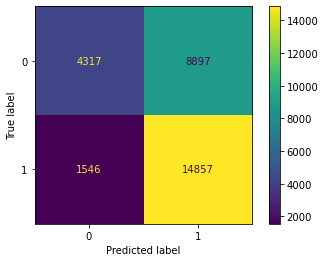

In [50]:
test_preds = logreg.predict(X_test)
test_probas = logreg.predict_proba(X_test)[:,1]

print(f"Test Acc: {logreg.score(X_test, y_test)}")
print(f"Test F1: {f1_score(y_test, test_preds)}")
print(f"Test ROCAUC: {roc_auc_score(y_test, test_probas)}")

plot_confusion_matrix(logreg, X_test, y_test);

## Decision Tree

In [51]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train)

tree.score(X_train, y_train)

0.6513337084974676

Test Acc: 0.6487827936658
Test F1: 0.741937084449737
Test ROCAUC: 0.6792034871337634


/Users/kellymullaney/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


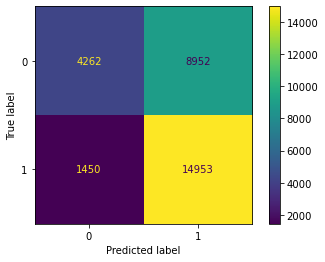

In [52]:
test_preds = tree.predict(X_test)
test_probas = tree.predict_proba(X_test)[:,1]

print(f"Test Acc: {tree.score(X_test, y_test)}")
print(f"Test F1: {f1_score(y_test, test_preds)}")
print(f"Test ROCAUC: {roc_auc_score(y_test, test_probas)}")

plot_confusion_matrix(tree, X_test, y_test);

## Random Forest

In [53]:
rf = RandomForestClassifier(max_depth=5)

rf.fit(X_train, y_train)

rf.score(X_train, y_train)

0.6561845807540799

Test Acc: 0.6510787723267043
Test F1: 0.7118880339020855
Test ROCAUC: 0.6810546700781542


/Users/kellymullaney/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


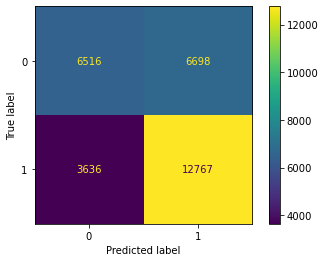

In [54]:
test_preds = rf.predict(X_test)
test_probas = rf.predict_proba(X_test)[:,1]

print(f"Test Acc: {rf.score(X_test, y_test)}")
print(f"Test F1: {f1_score(y_test, test_preds)}")
print(f"Test ROCAUC: {roc_auc_score(y_test, test_probas)}")

plot_confusion_matrix(rf, X_test, y_test);

We'd prefer to false negatives over false positives: would rather an animal be predicted to not be adopted, but actually is, rather than one that's predicted to be adopted but isn't.

Because of that, and a marginally higher ROC-AUC score, we'll choose our (mostly untuned and could definitely be improved) Random Forest model to pickle and deploy.

# Save Model for Deployment

In [55]:
# New library!
import pickle

In [56]:
# To save our model as a .sav file, use this code
# Note that rf is the variable of our model to save
pickle.dump(rf, open("rf_model.sav", 'wb'))

In [57]:
# Test that out, too!
# Loading up the model from the .sav file
loaded_model = pickle.load(open("rf_model.sav", 'rb'))

In [58]:
rf.score(X_test, y_test)

0.6510787723267043

In [59]:
# We can see it's the same as above
loaded_model.score(X_test, y_test)

0.6510787723267043

### Testing On a New Input

(aka what we'll need in our streamlit app!)

In [60]:
# We'll need to copy this over to streamlit
print(used_cols)

['Color_black', 'Fixed', 'Type_Cat', 'Type_Dog', 'Intake Condition_Not Normal', 'Female', 'Young']


In [61]:
# We want a new intake to look like this
X_test[:1]

,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
84048,False,True,True,False,False,False,False


In [62]:
# Needs to match these dtypes too
X_test.dtypes

Color_black                    bool
Fixed                          bool
Type_Cat                       bool
Type_Dog                       bool
Intake Condition_Not Normal    bool
Female                         bool
Young                          bool
dtype: object

In [63]:
# Example predictions on just one 
loaded_model.predict(X_test[:1])

array([1])

In [64]:
loaded_model.predict_proba(X_test[:1])

array([[0.40288648, 0.59711352]])

In [65]:
# Example row of new inputs
example_row = [True, False, False, True, False, False, True]

In [66]:
# Turning that into a dataframe
new_test_example = pd.DataFrame(dict(zip(used_cols, example_row)), index=[0])
new_test_example

,Color_black,Fixed,Type_Cat,Type_Dog,Intake Condition_Not Normal,Female,Young
0,True,False,False,True,False,False,True


In [68]:
# Proving we can use our model to predict on that!
loaded_model.predict_proba(new_test_example)

array([[0.32193036, 0.67806964]])